# Robust detrending, rereferencing, outlier detection, and inpainting, for-multichannel-data

Implementation of [1] in Python and experiments on real time series.  
Esteban Christiann (ENS Paris-Saclay) and Alexi Canesse (ENS de Lyon)

### Libraries Importation

In [1]:
import numpy as np
import scipy
import utils

### Data Importation

## 1. Robust detrending

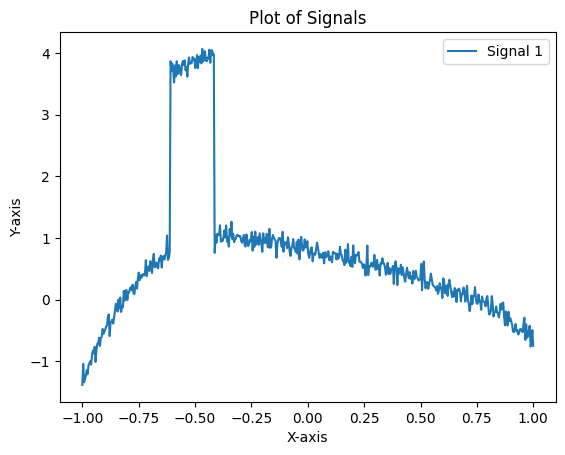

In [2]:
xvalues, synthetic_signal, _ = utils.generate_noisy_polynomial(degree=5, noise_level=0.1, num_points=512)
synthetic_signal[100:150] += 3
utils.plot_signals(xvalues, [synthetic_signal])

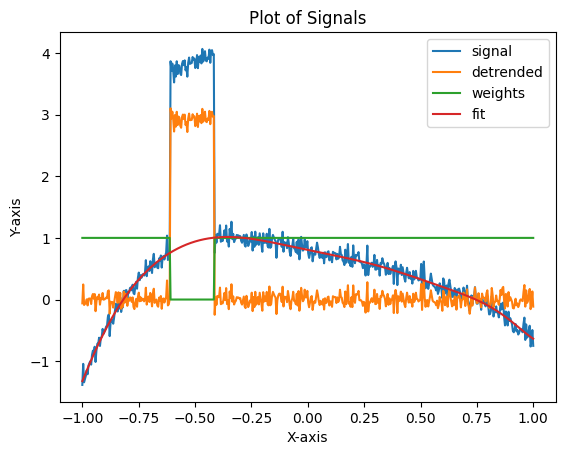

In [5]:
def robust_detrend(x, order, w=None, basis='polynomials', thresh=.5, niter=4):
     """
     Robustly removes trend from data.

     Parameters:
     - x: raw data
     - order: order of polynomial or number of sin/cosine pairs
     - w: weights
     - basis: 'polynomials' [default] or 'sinusoids', or user-provided matrix
     - thresh: threshold for outliers [default: .5 sd]
     - niter: number of iterations [default: 4]

     Returns:
     - original - trend: detrended data
     - trend: trend
     - w: updated weights
     - r: basis matrix used
     """
     # Generate basis matrix
     if isinstance(basis, np.ndarray):
          r = basis
     else:
          lin = np.linspace(-1, 1, x.shape[0])
          if basis == 'polynomials':
               r = np.column_stack([lin ** k for k in range(0, order + 1)])
          elif basis == 'sinusoids':
               r = np.column_stack([np.sin(2 * np.pi * k * lin / 2) for k in range(0, order + 1)] +
                                   [np.cos(2 * np.pi * k * lin / 2) for k in range(0, order + 1)])
          else:
               raise ValueError("Invalid basis type")

     # Initialize weights if not provided
     if w is None:
          w = np.ones_like(x, dtype=bool)[:, np.newaxis]
     
     # If the data is multichannel, the algorithm is applied to each channel independently 
     trend = x.copy()
     original = x.copy()
     if len(trend.shape) == 1:
          trend = trend[:, np.newaxis]
          original = original[:, np.newaxis]
     for i in range(niter):
          # If the data is multichannel, the algorithm is applied to each channel independently 
          for dim in range(trend.shape[1]):
               # Fit to basis
               coefficients, residuals, _, _ = np.linalg.lstsq(r[w[:, dim],:], original[w[:, dim], dim], rcond=None)
               trend[:,dim] = r @ coefficients
               # Update weights
               d = np.abs(trend[:,dim] - original[:,dim])
               w[:,dim] = [0 if dt > thresh * np.std(d) else 1 for dt in d]


     return original - trend, trend, w, r
          

detrended, trend, weights, _ = robust_detrend(synthetic_signal, 10, niter=5, thresh=1)
utils.plot_signals(xvalues, [synthetic_signal, detrended[:, 0], weights, trend], y_names=["signal", "detrended", "weights", "fit"])

## 2. Inpainting

## 3. Outlier Detection

## 4. Robust Rereferencing

## 5. Ringing Removal

## 6. Robust Detrending

[1] Alain de Cheveigné, Dorothée Arzounian,
Robust detrending, rereferencing, outlier detection, and inpainting for multichannel data,
NeuroImage,
Volume 172,
2018,
Pages 903-912,
ISSN 1053-8119,
https://doi.org/10.1016/j.neuroimage.2018.01.035.
(https://www.sciencedirect.com/science/article/pii/S1053811918300351)
Abstract: Electroencephalography (EEG), magnetoencephalography (MEG) and related techniques are prone to glitches, slow drift, steps, etc., that contaminate the data and interfere with the analysis and interpretation. These artifacts are usually addressed in a preprocessing phase that attempts to remove them or minimize their impact. This paper offers a set of useful techniques for this purpose: robust detrending, robust rereferencing, outlier detection, data interpolation (inpainting), step removal, and filter ringing artifact removal. These techniques provide a less wasteful alternative to discarding corrupted trials or channels, and they are relatively immune to artifacts that disrupt alternative approaches such as filtering. Robust detrending allows slow drifts and common mode signals to be factored out while avoiding the deleterious effects of glitches. Robust rereferencing reduces the impact of artifacts on the reference. Inpainting allows corrupt data to be interpolated from intact parts based on the correlation structure estimated over the intact parts. Outlier detection allows the corrupt parts to be identified. Step removal fixes the high-amplitude flux jump artifacts that are common with some MEG systems. Ringing removal allows the ringing response of the antialiasing filter to glitches (steps, pulses) to be suppressed. The performance of the methods is illustrated and evaluated using synthetic data and data from real EEG and MEG systems. These methods, which are mainly automatic and require little tuning, can greatly improve the quality of the data.
Keywords: EEG; MEG; LFP; ECoG; Artifact; ICA; CSP; DSS; SNS; CCA; Sensor noise; Detrending; Weighted regression; Robust statistics
